# Import Libraries

In [75]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/vision/stable/transforms.html)

In [76]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [77]:
# simple transform
simple_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                      #  transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])


train_transforms = transforms.Compose([

                        #transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
                        transforms.RandomRotation(5),  # Rotate images by -15 to +15 degrees
                        #transforms.Resize((28, 28)),
                        #transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 2.0)),  # Apply Gaussian Blur
                        #transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                        #transforms.RandomCrop(size=(28, 28), padding=4),  # Random crop with padding
                        #Cutout(n_holes=1, length=16),   # Apply Cutout with 1 hole of length 16
                        #transforms.RandomAffine(degrees=20, translate=(0.1,0.1), scale=(0.9, 1.1)),
                        #transforms.ColorJitter(brightness=0.2, contrast=0.2),
                        transforms.ToTensor(), 
                        transforms.Normalize((0.1307,), (0.3081,))
])

#exp = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
#exp_data = exp.train_data
#exp_data = exp.transform(exp_data.numpy())
#print('[Train]')
#print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
#print(' - Tensor Shape:', exp.train_data.size())
#print(' - min:', torch.min(exp_data))
#print(' - max:', torch.max(exp_data))
#print(' - mean:', torch.mean(exp_data))
#print(' - std:', torch.std(exp_data))
#print(' - var:', torch.var(exp_data))

# Dataset and Creating Train/Test Split

In [78]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [79]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

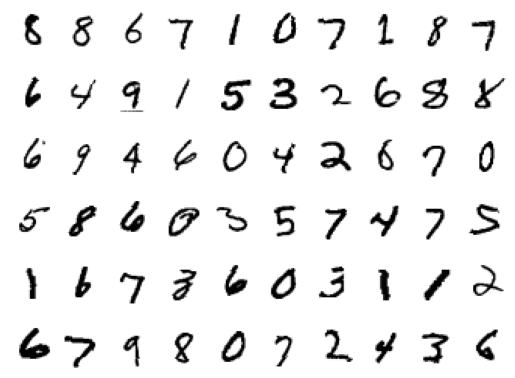

In [80]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

%matplotlib inline
import matplotlib.pyplot as plt
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# How did we get those mean and std values which we used above?

Let's run a small experiment

# The model
Let's start with the model we first saw

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [81]:
class Net_3(nn.Module):
    def __init__(self):
        super(Net_3, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, bias=False)  # 28x28x1 > 26x26x8
        self.bn1 = nn.BatchNorm2d(8)
        self.dropout1 = nn.Dropout(0.01)
        self.conv2 = nn.Conv2d(8, 16, 3, bias=False)  # 26x26x8 > 24x24x16
        self.bn2 = nn.BatchNorm2d(16)
        self.dropout2 = nn.Dropout(0.01)
        self.conv3 = nn.Conv2d(16, 8, 1, bias=False)  # 24x24x16 > 24x24x8
        self.bn3 = nn.BatchNorm2d(8)
        self.dropout3 = nn.Dropout(0.01)
        self.pool1 = nn.MaxPool2d(2, 2)  # 24x24x16 > 12x12x8
        self.conv4 = nn.Conv2d(8, 16, 3, bias=False)  # 12x12x8 > 10x10x16
        self.bn4 = nn.BatchNorm2d(16)
        self.dropout4 = nn.Dropout(0.01)
        self.conv5 = nn.Conv2d(16, 8, 3, bias=False)  # 10x10x16 > 8x8x8
        self.bn5 = nn.BatchNorm2d(8)
        self.dropout5 = nn.Dropout(0.01)
        self.conv6 = nn.Conv2d(8, 16, 3, bias=False)  # 8x8x8 > 6x6x16
        self.bn6 = nn.BatchNorm2d(16)
        self.dropout6 = nn.Dropout(0.01)
        self.conv7 = nn.Conv2d(16, 16, 3, bias=False)  # 6x6x16 > 4x4x16
        self.bn7 = nn.BatchNorm2d(16)
        self.dropout7 = nn.Dropout(0.01)
        self.gap = nn.AdaptiveAvgPool2d(1)  # 4x4x16 > 1x1x16
        self.conv8 = nn.Conv2d(16, 10, 1, bias=False)  # 1x1x16 > 1x1x10
        self.bn8 = nn.BatchNorm2d(10)
        self.dropout8 = nn.Dropout(0.01)
        
        #self.conv_out = nn.Conv2d(10, 10, 1)  # 1x1x14 > 1x1x10
        

    def forward(self, x):
        x = self.dropout2(F.relu(self.bn2(self.conv2(self.dropout1(F.relu(self.bn1(self.conv1(x))))))))
        x = self.pool1(self.dropout3(self.bn3(F.relu(self.conv3(x)))))
        x = self.dropout4(self.bn4(F.relu(self.conv4(x))))
        x = self.dropout6(self.bn6(F.relu(self.conv6(self.dropout5(self.bn5(F.relu(self.conv5(x))))))))
        x = self.dropout7(self.bn7(F.relu(self.conv7(x))))  # 1x1 convolution to map 14 channels to 10
        
        x = self.gap(x)  # Global average pooling to 1x1x14
        x = self.dropout8(self.bn8(F.relu(self.conv8(x))))
        #x = self.conv_out(x)  # 1x1 convolution to map 14 channels to 10
        x = x.view(-1, 10)  # Flatten to (batch_size, 10)
        return F.log_softmax(x, dim=-1)
 

In [82]:

from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net_3().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           1,152
       BatchNorm2d-5           [-1, 16, 24, 24]              32
           Dropout-6           [-1, 16, 24, 24]               0
            Conv2d-7            [-1, 8, 24, 24]             128
       BatchNorm2d-8            [-1, 8, 24, 24]              16
           Dropout-9            [-1, 8, 24, 24]               0
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
      BatchNorm2d-12           [-1, 16, 10, 10]              32
          Dropout-13           [-1, 16, 10, 10]               0
           Conv2d-14              

# Training and Testing

All right, so we have 6.3M params, and that's too many, we know that. But the purpose of this notebook is to set things right for our future experiments.

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [83]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [84]:
from torch.optim.lr_scheduler import StepLR
model =  Net_3().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.04056692495942116 Batch_id=468 Accuracy=94.19: 100%|██████████| 469/469 [00:04<00:00, 112.79it/s] 



Test set: Average loss: 0.0682, Accuracy: 9834/10000 (98.34%)

EPOCH: 1


Loss=0.09892521053552628 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:04<00:00, 107.37it/s] 



Test set: Average loss: 0.0451, Accuracy: 9882/10000 (98.82%)

EPOCH: 2


Loss=0.04262882471084595 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:04<00:00, 112.34it/s] 



Test set: Average loss: 0.0361, Accuracy: 9891/10000 (98.91%)

EPOCH: 3


Loss=0.029702870175242424 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:04<00:00, 107.95it/s] 



Test set: Average loss: 0.0351, Accuracy: 9910/10000 (99.10%)

EPOCH: 4


Loss=0.022595202550292015 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:04<00:00, 110.55it/s]



Test set: Average loss: 0.0309, Accuracy: 9901/10000 (99.01%)

EPOCH: 5


Loss=0.023090852424502373 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:04<00:00, 110.81it/s]



Test set: Average loss: 0.0321, Accuracy: 9906/10000 (99.06%)

EPOCH: 6


Loss=0.02695859968662262 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:04<00:00, 108.71it/s]  



Test set: Average loss: 0.0230, Accuracy: 9937/10000 (99.37%)

EPOCH: 7


Loss=0.03999937325716019 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:03<00:00, 122.77it/s] 



Test set: Average loss: 0.0221, Accuracy: 9938/10000 (99.38%)

EPOCH: 8


Loss=0.018076995387673378 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:03<00:00, 118.27it/s] 



Test set: Average loss: 0.0224, Accuracy: 9933/10000 (99.33%)

EPOCH: 9


Loss=0.08017237484455109 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:03<00:00, 118.64it/s]  



Test set: Average loss: 0.0213, Accuracy: 9940/10000 (99.40%)

EPOCH: 10


Loss=0.019701384007930756 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:04<00:00, 116.45it/s] 



Test set: Average loss: 0.0219, Accuracy: 9935/10000 (99.35%)

EPOCH: 11


Loss=0.04665173590183258 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:03<00:00, 124.83it/s]  



Test set: Average loss: 0.0219, Accuracy: 9936/10000 (99.36%)

EPOCH: 12


Loss=0.01849552057683468 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:03<00:00, 118.24it/s]  



Test set: Average loss: 0.0213, Accuracy: 9935/10000 (99.35%)

EPOCH: 13


Loss=0.13115531206130981 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:03<00:00, 122.72it/s]  



Test set: Average loss: 0.0206, Accuracy: 9940/10000 (99.40%)

EPOCH: 14


Loss=0.04560170695185661 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:04<00:00, 109.90it/s]  



Test set: Average loss: 0.0209, Accuracy: 9938/10000 (99.38%)



In [16]:
train_losses

[tensor(2.3023, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3016, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3035, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3011, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.3003, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2997, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2973, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2960, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2955, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2941, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2925, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2884, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2894, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2852, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2840, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(2.2809, device='cuda:0', grad_fn=<NllLossBackward0>),
 tensor(

In [17]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

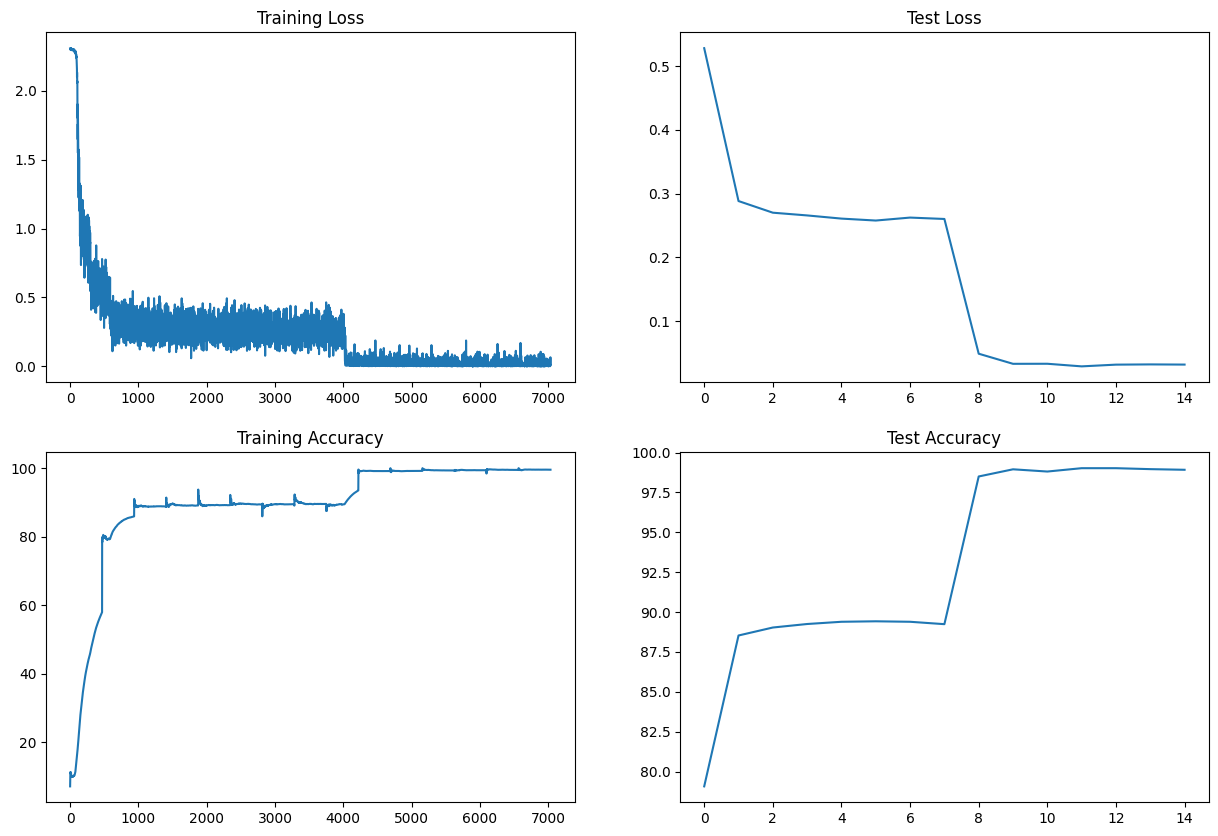

In [18]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")